In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob

from os.path import join
from astropy.io import fits

from mixcoatl.sourcegrid import DistortedGrid

from lsst.obs.lsst import LsstCamMapper as camMapper
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms

Currently the source catalogs for the CCD spacing tests are divided into a different jobHarness runs due to data acquisition troubles.  These are:
* 6872D
* 6873D

I have placed the results for these runs in the directory `/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/` listed by run number. 

Within each run directory are a list of subdirectories corresponding to each exposure at a different projector position.  They are labeld by the projector X/Y position and the acquisition number.

In [23]:
## Print out all the result directories
results_dirs = sorted(glob.glob(join('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing', 
                                'spacing_*')))
for result_dir in results_dirs:
    print(result_dir)

/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_0.0_-21.0_000
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_0.0_21.0_001
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_106.6_-211.9_006
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_106.6_-253.9_005
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_106.6_-295.9_004
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_127.6_-190.9_015
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_127.6_-232.9_014
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_127.6_-274.9_013
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_148.6_-211.9_009
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_148.6_-253.9_008
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_148.6_-295.9_007
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/68

Within each of these subdirectories should be two source catalog files, corresponding to the two CCDs that the projector was positioned between such that both would be illuminated by half of the source grid.

In [24]:
## Print out CCD source catalog pairs.
infile1, infile2 = glob.glob(join(results_dirs[0], '*_source_catalog.cat'))
print(infile1)
print(infile2)

/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_0.0_-21.0_000/R22_S10_source_catalog.cat
/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6872D_spacing/spacing_0.0_-21.0_000/R22_S11_source_catalog.cat


For visualization, here are the scatter plots of the identified sources for the two CCDs in the first subdirectory.

Notice that the grid is divided between the two sensors.

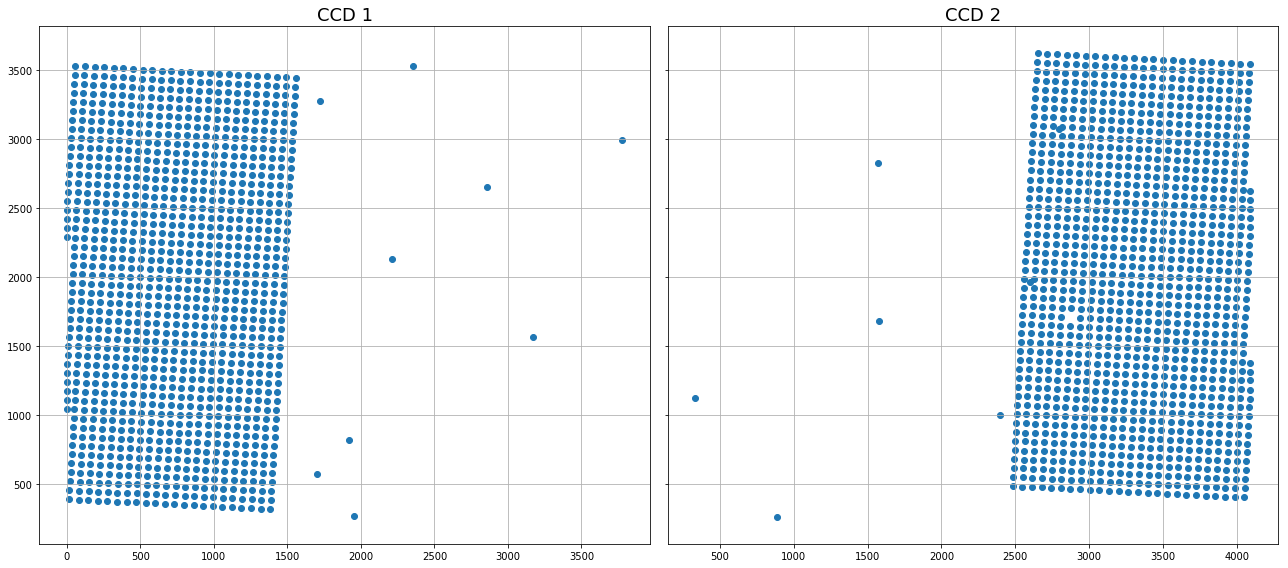

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

src1 = fits.getdata(infile1)
srcX1 = src1['base_SdssShape_x']
srcY1 = src1['base_SdssShape_y']

src2 = fits.getdata(infile2)
srcX2 = src2['base_SdssShape_x']
srcY2 = src2['base_SdssShape_y']

axes[0].scatter(srcX1, srcY1)
axes[1].scatter(srcX2, srcY2)

axes[0].set_title('CCD 1', fontsize=18)
axes[1].set_title('CCD 2', fontsize=18)
axes[0].grid(which='both')
axes[1].grid(which='both')
plt.tight_layout()

Now the challenge is to match up CCD 1 and CCD 2, using the information provided by the grid of spots split between the two.  For this I've been fitting a "model grid" represented as `SourceGrid` class in my `mixcoatl` Python module (see GitHub repository `https://github.com/snyder18/mixcoatl/tree/u/snyder18/grid_fitting`).  This will determine the rotation of the grid and the grid center points, in each of the CCDs respective pixel coordinate system.

-84.74463023281993 1968.6030115573424 -0.05547532678132394


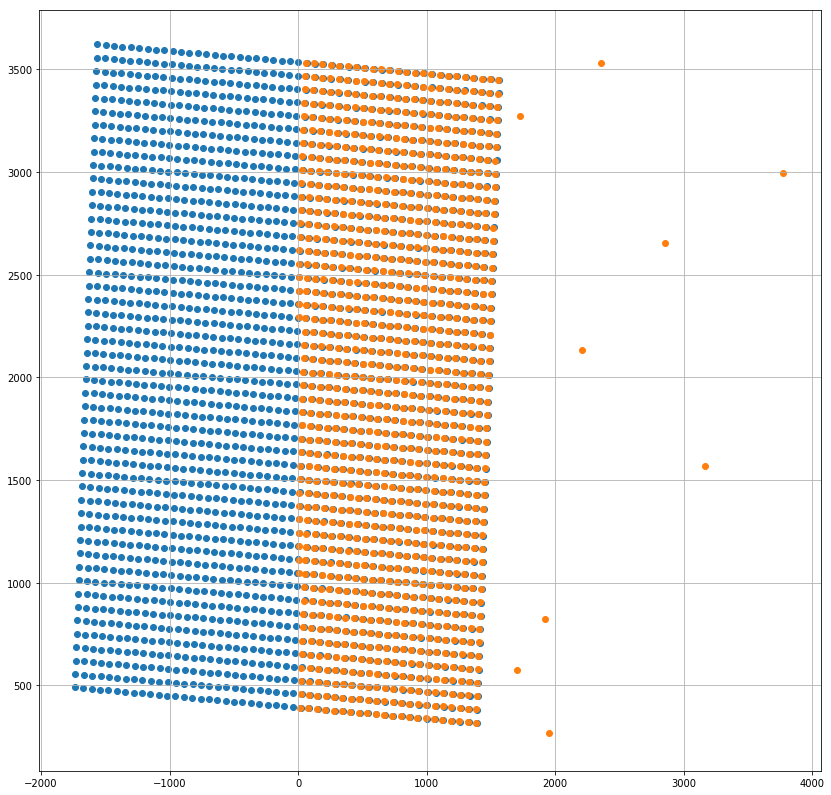

In [26]:
## Need an intelligent guess (here is one that works, but others won't since grid is periodic)
x0_guess = -100.
y0_guess = 2000.

model_grid1 = SourceGrid.from_source_catalog(src1, y0_guess=y0_guess, x0_guess=x0_guess)

fig, ax = plt.subplots(1, 1, figsize=(14, 14))

gY, gX = model_grid1.make_grid(49, 49)
srcX = src1['base_SdssShape_x']
srcY = src1['base_SdssShape_y']

ax.scatter(gX, gY)
ax.scatter(srcX, srcY)
ax.grid(which='both')

print(model_grid1.x0, model_grid1.y0, model_grid1.theta)

4129.784652946945 1969.9785266312017 -0.05401382441303926


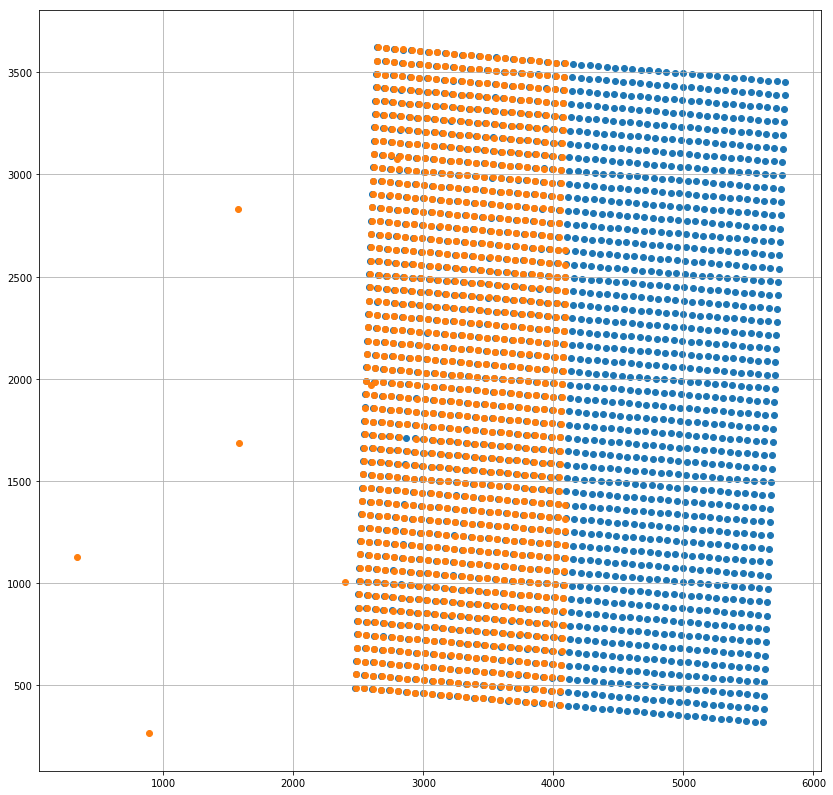

In [27]:
## Need an intelligent guess (here is one that works, but others won't since grid is periodic)
x0_guess = 4150.
y0_guess = 2000.

model_grid2 = SourceGrid.from_source_catalog(src2, y0_guess=y0_guess, x0_guess=x0_guess)

fig, ax = plt.subplots(1, 1, figsize=(14, 14))

gY, gX = model_grid2.make_grid(49, 49)
srcX = src2['base_SdssShape_x']
srcY = src2['base_SdssShape_y']

ax.scatter(gX, gY)
ax.scatter(srcX, srcY)
ax.grid(which='both')

print(model_grid2.x0, model_grid2.y0, model_grid2.theta)

We now have the grid center in each CCDs respective pixel coordinate system.  It is now possible to determine the transform between these coordinate systems, which will determine the relative spacing between the CCDs and their possible rotations.


Grid 1: -84.74463023281993 1968.6030115573424 -0.05547532678132394
Grid 2: 4129.784652946945 1969.9785266312017 -0.05401382441303926


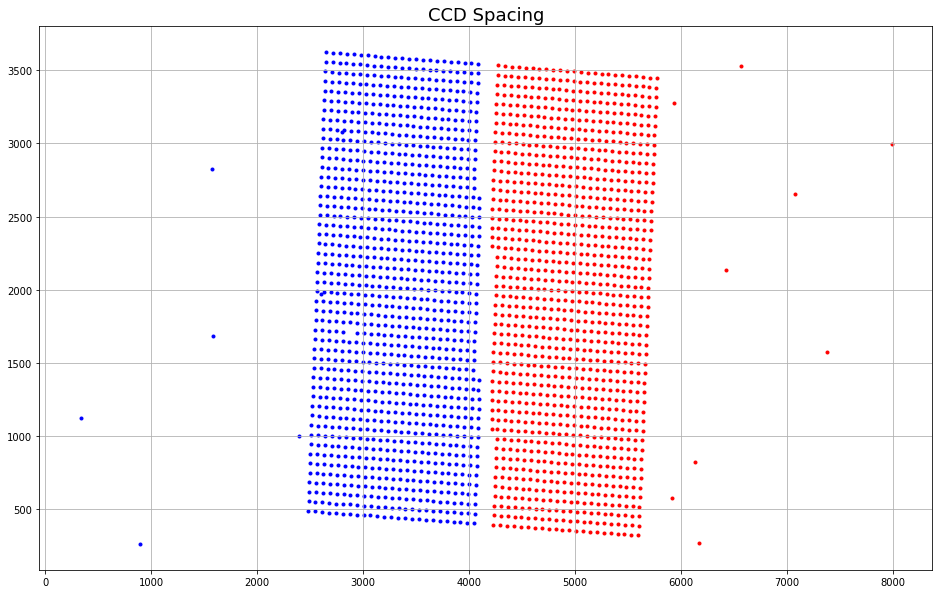

In [28]:
print('Grid 1:', model_grid1.x0, model_grid1.y0, model_grid1.theta)
print('Grid 2:', model_grid2.x0, model_grid2.y0, model_grid2.theta)

## Ignore rotation for now
dy0 = model_grid2.y0 - model_grid1.y0
dx0 = model_grid2.x0 - model_grid1.x0

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
srcX1 = src1['base_SdssShape_x']
srcY1 = src1['base_SdssShape_y']

srcX2 = src2['base_SdssShape_x']
srcY2 = src2['base_SdssShape_y']

ax.scatter(srcX1+dx0, srcY1+dy0, color='red', marker='.')
ax.scatter(srcX2, srcY2, color='blue', marker='.')
ax.set_title('CCD Spacing', fontsize=18)
ax.grid(which='both')